## Vanishing/exploding gradients problem

In [2]:
def logit(z):
    return 1/ (1 + np.exp(-z))

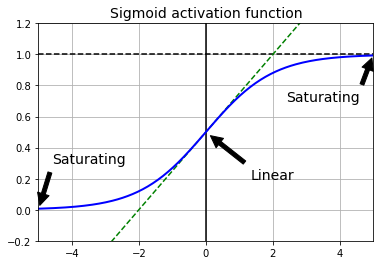

In [6]:
import numpy as np
import matplotlib.pyplot as plt

z = np.linspace(-5,5,200)

plt.plot([-5,-5], [0,0], 'k-')
plt.plot([-5,5], [1,1], 'k--')
plt.plot([0,0], [-0.2,1.2], 'k-')
plt.plot([-5,5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), 'b-', linewidth=2)
props= dict(facecolor='black',shrink=0.1)

plt.annotate('Saturating', xytext=(3.5,0.7), xy=(5,1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5,0.3), xy=(-5,0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5),arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### Xavier and He Initialisation

In [8]:
# The book uses fully_connected isntaead of dense but it is preferable to use dense

import tensorflow as tf

#reset_graph()
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28 *28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [9]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

W0525 10:49:40.651641 18268 deprecation.py:323] From <ipython-input-9-da109dac52d3>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


### Non Saturating Activation function

In [10]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

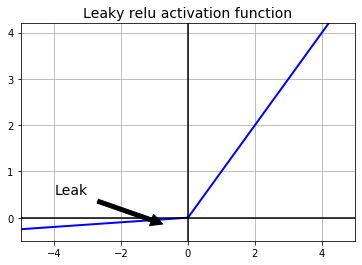

In [11]:
# plotting leaky relu

plt.plot(z, leaky_relu(z, 0.05), "b-",linewidth=2)
plt.plot([-5,5],[0,0], 'k-')
plt.plot([0,0], [-0.5, 4.2],'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)

plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-0.5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky relu activation function", fontsize=14)
plt.axis([-5,5,-0.5,4.2])

plt.show()

### Implementing leaky relu in tensorflow

In [12]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")

In [14]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

W0525 11:03:34.741143 18268 deprecation.py:506] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [23]:
X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [24]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [26]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [27]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

W0525 11:23:53.313188 18268 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [29]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [31]:
# loading the dataset tf.examples.tutorials.mnist is depreciated

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1,28 *28)/ 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28)/ 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [32]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [33]:
n_epochs = 40
batch_size =50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
            acc_valid = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
            print(epoch, acc_batch, acc_valid)
    
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 0.9 0.9046
5 0.94 0.9494
10 0.9 0.9658
15 0.94 0.9714
20 1.0 0.9732
25 1.0 0.9752
30 0.98 0.9752
35 1.0 0.9768


### ELU function

In [35]:
def elu(z, alpha=1):
    return np.where(z<0, alpha* (np.exp(z)- 1), z)

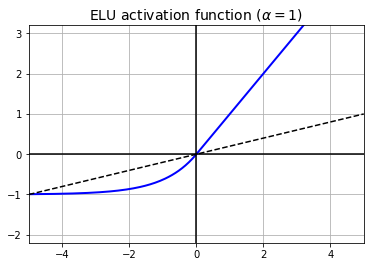

In [36]:
plt.plot(z, elu(z),"b-", linewidth=2)
plt.plot([-5,5], [0,0], 'k-')
plt.plot([-5,5], [-1,1], 'k--')
plt.plot([0,0], [-2.2,3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5,5,-2.2,3.2])

plt.show()

In [39]:
def reset_graph():
    tf.reset_default_graph()
    tf.set_random_seed(42)
    np.random.seed(42)

In [40]:
# implementing ELU in tensorflow
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [41]:
hidden1 = tf.layers.dense(X, n_hidden1,activation=tf.nn.elu, name="hidden1")